<a href="https://colab.research.google.com/github/3atom1take1/kaggle/blob/master/IID_Ensemblefix_190706_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIGNATE API設定

In [4]:
# SIGNATE　apiの利用
## あらかじめsignate.jsonをアップロードしておく
!mkdir -p ~/.signate
!cp signate.json ~/.signate/

!pip install signate

In [5]:
!signate download --competition-id=162

data_definition.txt

sample_submit.tsv

test_goto.tsv

train_goto.tsv

test_genba.tsv

train_genba.tsv


Download completed.


# 前処理

In [0]:
# 基本ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
pd.set_option('display.max_columns',200)
# pd.set_option('display.max_rows', 200)

In [0]:
df_genba_train = pd.read_csv('train_genba.tsv',delimiter = '\t', encoding = 'utf-8')
df_genba_sub = pd.read_csv('test_genba.tsv',delimiter='\t',encoding = 'utf-8')
df_goto_train  = pd.read_csv('train_goto.tsv', delimiter = '\t',encoding='utf-8')
df_goto_sub = pd.read_csv('test_goto.tsv',delimiter = '\t', encoding = 'utf-8')
sample_sub = pd.read_csv('sample_submit.tsv', delimiter= '\t', encoding = 'utf-8')
data_definition = pd.read_csv('data_definition.txt',delimiter = '\t', encoding = 'utf-8')

In [0]:
# data_definition

In [0]:
# genbaデータとgotoデータの統合
df_merge_train = pd.merge(df_goto_train,df_genba_train, on = 'pj_no')
df_merge_sub = pd.merge(df_goto_sub,df_genba_sub, on = 'pj_no')

In [0]:
df_merge_sub['keiyaku_pr'] = np.nan

In [0]:
# 前処理のため学習データと提出データを統合
df_merge = pd.concat([df_merge_train,df_merge_sub],join = 'inner')

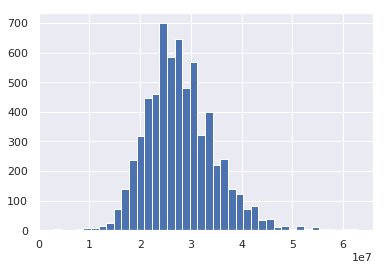

In [13]:
sns.set()
df_merge['keiyaku_pr'].hist(bins = 40)

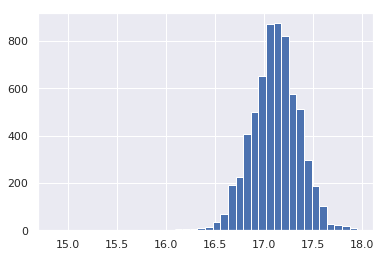

In [14]:
# 目的変数をlogをとる
df_merge['keiyaku_pr'] = np.log1p(df_merge['keiyaku_pr'])
df_merge['keiyaku_pr'].hist(bins = 40)

In [0]:
# 不要columnの削除
drop_columns = [
                'pj_no',
                'id',
                'yoto2',
                'kempei2',
                'yoseki2',
                'bastei_nm1',
                'teiho1',
                'rosen_nm2',
                'eki_nm2',
                'bas_toho2',
                'eki_kyori2',
                'bastei_nm2',
                'teiho2',
                'kobetsu1',
                'kobetsu2',
                'kobetsu3',
                'kobetsu4',
               ]
df_merge = df_merge.drop(columns = drop_columns)

(10734, 141)


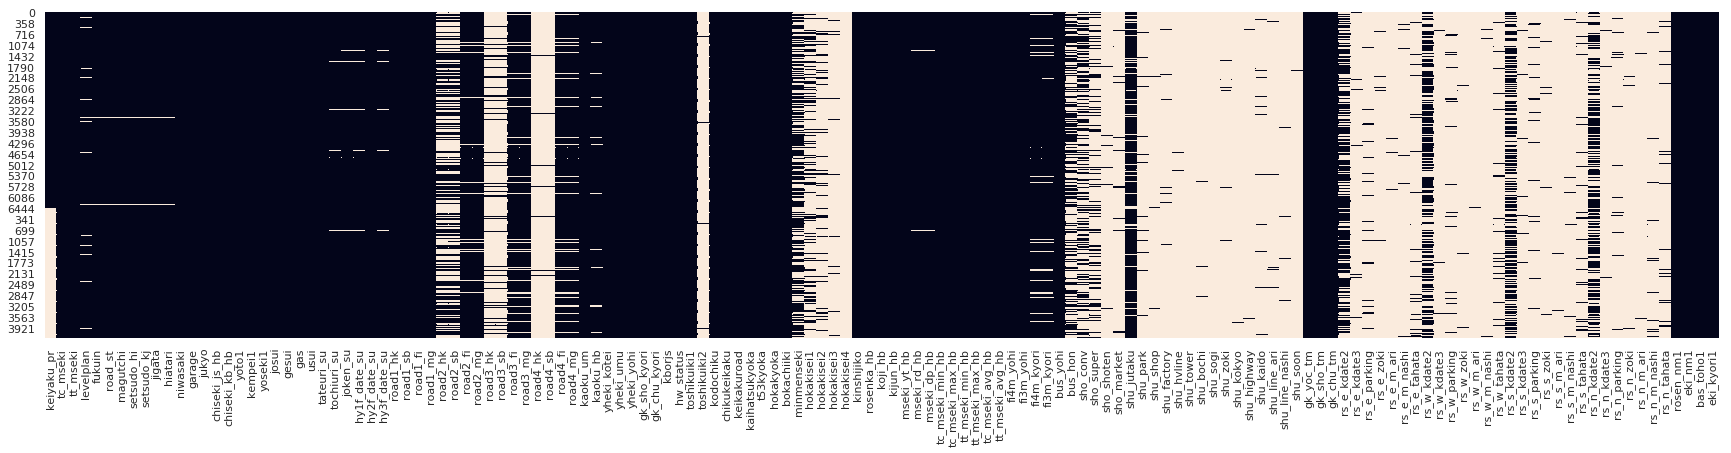

In [16]:
# 欠損値の確認
print(df_merge.shape)
sns.set()
plt.figure(figsize=(30,6))
sns.heatmap(df_merge.isnull(),cbar=False)

In [0]:
# #欠損値処理
# # 欠損値の割合がa以上の特徴量を削除
# a=0.8
# b=len(df_merge)*a
# index=df_merge.isnull().sum() < b
# index_dict=dict(index)
# columns_list=list(df_merge.columns)
# for i in range(len(columns_list)):
#     if index_dict[columns_list[i]]==False:
#         df_merge=df_merge.drop(columns_list[i],axis=1)        

In [0]:
# df_merge.isnull().sum()[df_merge.isnull().sum()>0].sort_values(ascending = False)

In [0]:
# df_merge['minmenseki'].hist(bins = 50)

In [0]:
df_merge = df_merge.replace({'○':int(1)})

In [0]:
# 欠損値補完
#変数を型ごとに分ける
df_int=df_merge.select_dtypes(include='int').columns
df_float=df_merge.select_dtypes(include='float').columns

df_merge[df_int] = df_merge[df_int].fillna(0)
df_merge[df_float] = df_merge[df_float].fillna(0)

In [0]:
# ダミー変数の取得
df_merge = pd.get_dummies(df_merge,drop_first = True)

In [0]:
# print(df_merge.shape)
# sns.set()
# plt.figure(figsize=(15,6))
# sns.heatmap(df_merge.isnull(),cbar=False)

In [0]:
df_merge_train = df_merge[:len(df_merge_train)]
df_merge_sub = df_merge[len(df_merge_train):]
df_merge_sub = df_merge_sub.drop(columns = 'keiyaku_pr')

# モデル構築

# 重回帰モデル

In [25]:
# データ分割
target = 'keiyaku_pr'
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df_merge_train,test_size = 0.2, random_state = 2)
columns = df_merge_train.columns.values

X_train = df_train.drop(columns = target)
y_train = df_train[target]

X_test = df_test.drop(columns = target)
y_test = df_test[target]


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5168, 2126)
(5168,)
(1293, 2126)
(1293,)


In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(n_jobs = -1,normalize = False)
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [0]:
# 価格予測
y_train_pred = np.expm1(lr_model.predict(X_train))
y_test_pred =  np.expm1(lr_model.predict(X_test))

# logを外す
y_train =np.expm1(y_train)
y_test =np.expm1(y_test)

In [28]:
# 目的変数logとる
def mean_absolute_percentage_error(y_test, y_test_pred): 
    return np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print(y_test.describe())
print('train_RMSE:' ,train_rmse)
print('test_RMSE:' ,test_rmse)
print('train_MAPE',mean_absolute_percentage_error(y_train, y_train_pred))
print('test_MAPE',mean_absolute_percentage_error(y_test, y_test_pred))

count    1.293000e+03
mean     2.743737e+07
std      6.760280e+06
min      7.200000e+06
25%      2.280000e+07
50%      2.680000e+07
75%      3.120000e+07
max      5.680000e+07
Name: keiyaku_pr, dtype: float64
train_RMSE: 2154292.299990281
test_RMSE: 3542642.1458381596
train_MAPE 5.78600869438127
test_MAPE 9.20975028305578


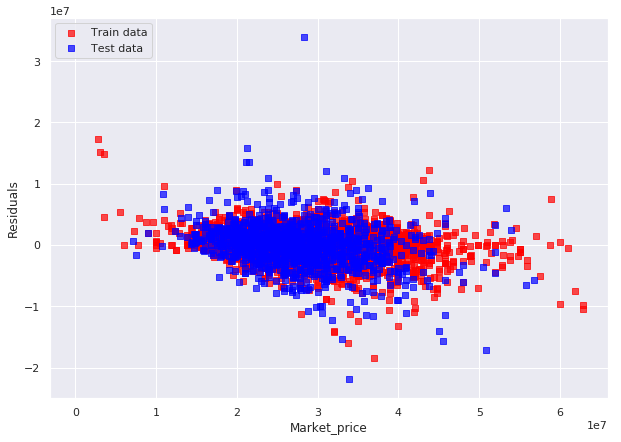

In [29]:
%matplotlib inline
sns.set()

# プロット
plt.figure(figsize = (10, 7))
plt.scatter(y_train, y_train_pred - y_train, c = 'red', marker = 's', s = 35, alpha = 0.7, label = 'Train data')
plt.scatter(y_test, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Market_price')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2)
# plt.xlim([-10, 20000000])
# plt.ylim([-10000000,10000000])
plt.show()

Linear Regression  picked 2055 variables and eliminated the other 71 variables


Text(0.5, 1.0, 'Coefficients in the Linear Regression Model')

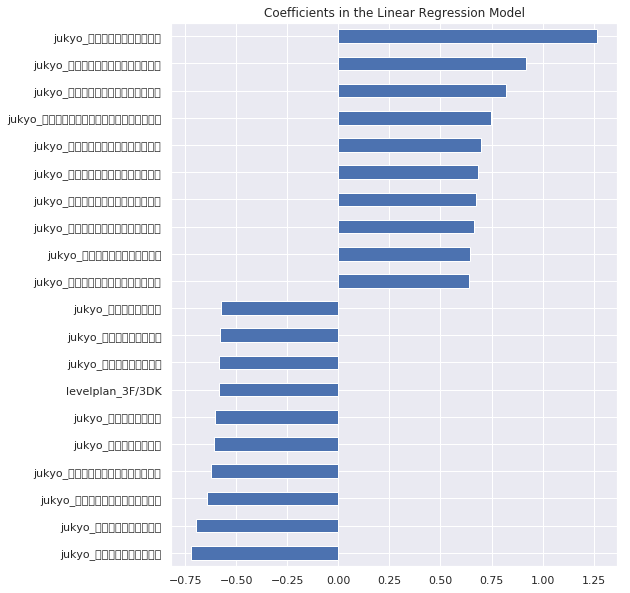

In [30]:
coef = pd.Series(lr_model.coef_, index = X_train.columns)
print("Linear Regression  picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Regression Model")

In [31]:
# 偏回帰係数
print(pd.DataFrame({"Name":X_train.columns,
                    "Coefficients":np.abs(lr_model.coef_)}).sort_values(by='Coefficients',ascending =False) )
 
# 切片 (誤差)
print(lr_model.intercept_)

                          Name  Coefficients
530          jukyo_埼玉県上尾市大字壱丁目      1.267465
248       jukyo_埼玉県さいたま市大宮区櫛引町      0.916459
247       jukyo_埼玉県さいたま市大宮区桜木町      0.819174
359   jukyo_埼玉県さいたま市西区大字中野林字條敷      0.745585
572           jukyo_埼玉県久喜市久喜中央      0.719681
244       jukyo_埼玉県さいたま市大宮区天沼町      0.699732
817           jukyo_埼玉県吉川市大字吉川      0.698142
238       jukyo_埼玉県さいたま市大宮区上小町      0.686140
392       jukyo_埼玉県さいたま市見沼区堀崎町      0.675802
243       jukyo_埼玉県さいたま市大宮区大成町      0.666614
819        jukyo_埼玉県吉川市大字平沼字川端      0.645319
382         jukyo_埼玉県さいたま市西区高木      0.642444
211       jukyo_埼玉県さいたま市北区東大成町      0.641140
1393      jukyo_埼玉県比企郡川島町大字下伊草      0.624833
194       jukyo_埼玉県さいたま市中央区円阿弥      0.621217
421        jukyo_埼玉県さいたま市見沼区春岡      0.619467
828             jukyo_埼玉県吉川市高富      0.607202
821             jukyo_埼玉県吉川市平沼      0.605540
539        jukyo_埼玉県上尾市大字瓦葺字狢谷      0.603900
1143           jukyo_埼玉県戸田市氷川町      0.596861
561             jukyo_埼玉県上尾市瓦葺      0.593944
113       

# Lasso回帰

In [0]:
# データ分割
target = 'keiyaku_pr'
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df_merge_train,test_size = 0.2, random_state = 2)
columns = df_merge_train.columns.values

X_train = df_train.drop(columns = target)
y_train = df_train[target]

X_test = df_test.drop(columns = target)
y_test = df_test[target]

In [0]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [0]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [0]:
ridge_model = Ridge()
alphas = [0.1,0.3,0.5,0.7,0.9,1.2,1.5,1.8,2]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()
            for alpha in alphas]

Text(0, 0.5, 'rmse')

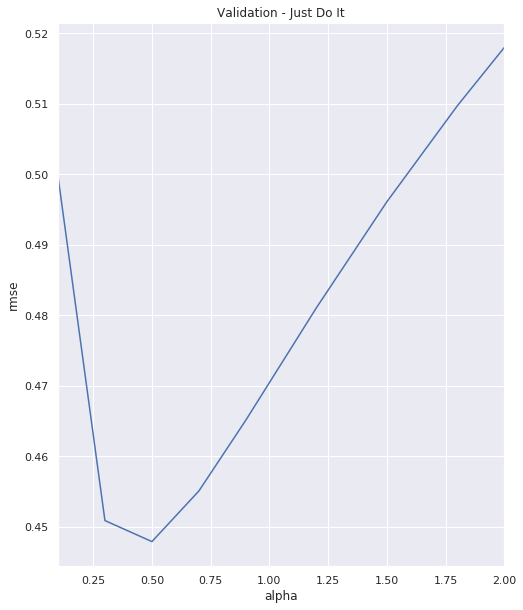

In [36]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [37]:
cv_ridge.min()

0.44790016563247137

In [38]:
lasso_model = LassoCV(alphas = [0.1,0.3,0.5,0.7,0.9,1.2,1.5,1.8,2]).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [39]:
rmse_cv(lasso_model).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

0.17206593551468236

Lasso picked 14 variables and eliminated the other 2112 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

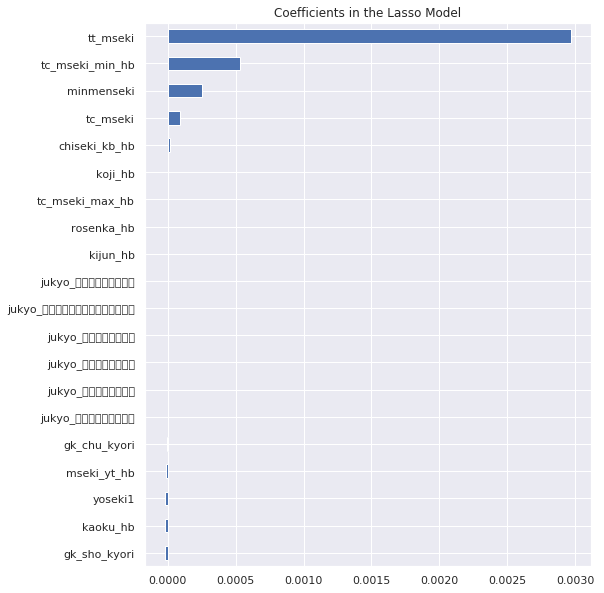

In [40]:
coef = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [0]:
# 価格予測
y_train_pred = np.expm1(lasso_model.predict(X_train))
y_test_pred =  np.expm1(lasso_model.predict(X_test))

# logを外す
y_train =np.expm1(y_train)
y_test =np.expm1(y_test)

In [42]:
# Lasso回帰結果
def mean_absolute_percentage_error(y_test, y_test_pred): 
    return np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print(y_test.describe())
print('train_RMSE:' ,train_rmse)
print('test_RMSE:' ,test_rmse)
print('train_MAPE',mean_absolute_percentage_error(y_train, y_train_pred))
print('test_MAPE',mean_absolute_percentage_error(y_test, y_test_pred))

count    1.293000e+03
mean     2.743737e+07
std      6.760280e+06
min      7.200000e+06
25%      2.280000e+07
50%      2.680000e+07
75%      3.120000e+07
max      5.680000e+07
Name: keiyaku_pr, dtype: float64
train_RMSE: 4748797.427424677
test_RMSE: 4537383.408990857
train_MAPE 13.335617728420315
test_MAPE 13.510401695003651


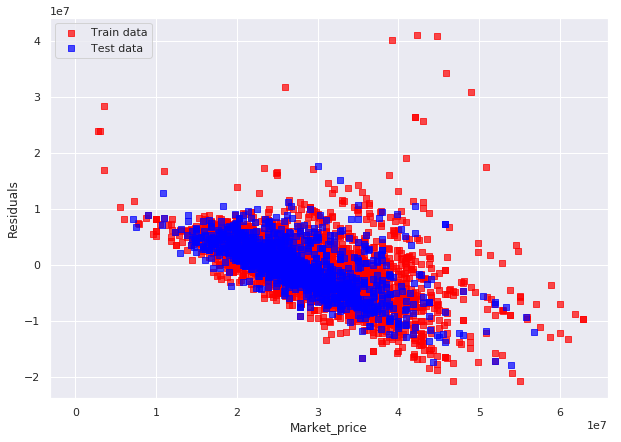

In [43]:
%matplotlib inline
sns.set()

# プロット
plt.figure(figsize = (10, 7))
plt.scatter(y_train, y_train_pred - y_train, c = 'red', marker = 's', s = 35, alpha = 0.7, label = 'Train data')
plt.scatter(y_test, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Market_price')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2)
# plt.xlim([-10, 20000000])
# plt.ylim([-10000000,10000000])
plt.show()

# Ridgh回帰

In [0]:
from sklearn.linear_model import RidgeCV
# データ分割
target = 'keiyaku_pr'
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df_merge_train,test_size = 0.2, random_state = 2)
columns = df_merge_train.columns.values

X_train = df_train.drop(columns = target)
y_train = df_train[target]

X_test = df_test.drop(columns = target)
y_test = df_test[target]

In [0]:
ridge_model = RidgeCV(alphas = [0.1,0.3,0.5,0.7,0.9,1.2,1.5,1.8,2]).fit(X_train, y_train)

In [46]:
# 価格予測
y_train_pred = np.expm1(ridge_model.predict(X_train))
y_test_pred =  np.expm1(ridge_model.predict(X_test))

# logを外す
y_train =np.expm1(y_train)
y_test =np.expm1(y_test)

# 目的変数logとる
def mean_absolute_percentage_error(y_test, y_test_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_test_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print(y_test.describe())
print('train_RMSE:' ,train_rmse)
print('test_RMSE:' ,test_rmse)
print('train_MAPE',mean_absolute_percentage_error(y_train, y_train_pred))
print('test_MAPE',mean_absolute_percentage_error(y_test, y_test_pred))

count    1.293000e+03
mean     2.743737e+07
std      6.760280e+06
min      7.200000e+06
25%      2.280000e+07
50%      2.680000e+07
75%      3.120000e+07
max      5.680000e+07
Name: keiyaku_pr, dtype: float64
train_RMSE: 2348476.349969741
test_RMSE: 2906078.8170883744
train_MAPE 6.688705696196072
test_MAPE 8.188948375565783


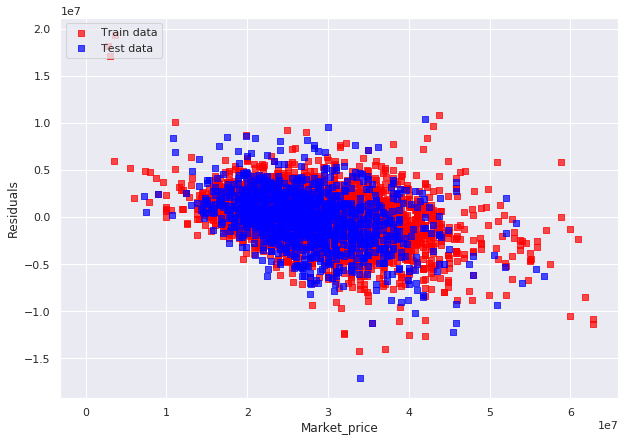

In [47]:
%matplotlib inline
sns.set()

# プロット
plt.figure(figsize = (10, 7))
plt.scatter(y_train, y_train_pred - y_train, c = 'red', marker = 's', s = 35, alpha = 0.7, label = 'Train data')
plt.scatter(y_test, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Market_price')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2)
# plt.xlim([-10, 20000000])
# plt.ylim([-10000000,10000000])
plt.show()

In [48]:
coef = pd.Series(ridge_model.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 1700 variables and eliminated the other 426 variables


In [0]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

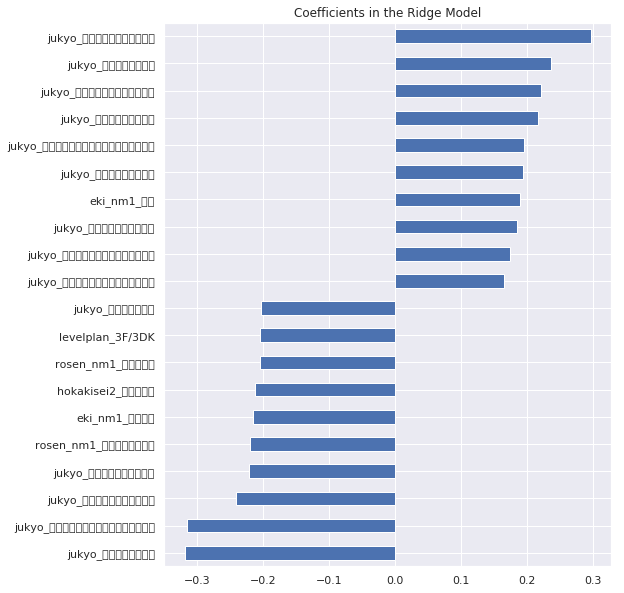

In [50]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

# XGBoost

In [0]:
# XGBoostモデル構築
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
# データ分割
target = 'keiyaku_pr'
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df_merge_train,test_size = 0.2, random_state = 2)
columns = df_merge_train.columns.values

X_train = df_train.drop(columns = target)
y_train = df_train[target]

X_test = df_test.drop(columns = target)
y_test = df_test[target]

In [52]:
# XGBoost
do_grid_search = False

def run_grid_search():
  params={
        'eta': [0.1,0.5,0.8,1],
        'max_depth': [3,5,7],
        'min_child_weight':[0.5,0.8,1],
        'n_estimators': [50,100,200],
        'subsample': [0.8, 1],
        'colsample_bytree': [1.0],
  }
  xgb_model = GridSearchCV(xgb.XGBRegressor(),params,cv = 5,verbose = 1)
  xgb_model.fit(X_train,y_train)
  return xgb_model

if do_grid_search:
  xgb_model = run_grid_search()
  print(xgb_model.best_estimator_)
  print(xgb_model.best_score_)
else:
    xgb_model =xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.05, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=0.5, missing=None, n_estimators=100,
            nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1,cv = 5,verbose = 1)
    xgb_model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:54:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
# 価格予測
y_train_pred = np.expm1(xgb_model.predict(X_train))
y_test_pred =  np.expm1(xgb_model.predict(X_test))

# logを外す
y_train =np.expm1(y_train)
y_test =np.expm1(y_test)

In [54]:
# 目的変数logとる
def mean_absolute_percentage_error(y_test, y_test_pred): 
    return np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print(y_test.describe())
print('train_RMSE:' ,train_rmse)
print('test_RMSE:' ,test_rmse)
print('train_MAPE',mean_absolute_percentage_error(y_train, y_train_pred))
print('test_MAPE',mean_absolute_percentage_error(y_test, y_test_pred))

count    1.293000e+03
mean     2.743737e+07
std      6.760280e+06
min      7.200000e+06
25%      2.280000e+07
50%      2.680000e+07
75%      3.120000e+07
max      5.680000e+07
Name: keiyaku_pr, dtype: float64
train_RMSE: 1969811.4676448135
test_RMSE: 2898309.0046790484
train_MAPE 5.531530185750165
test_MAPE 8.32318751574407


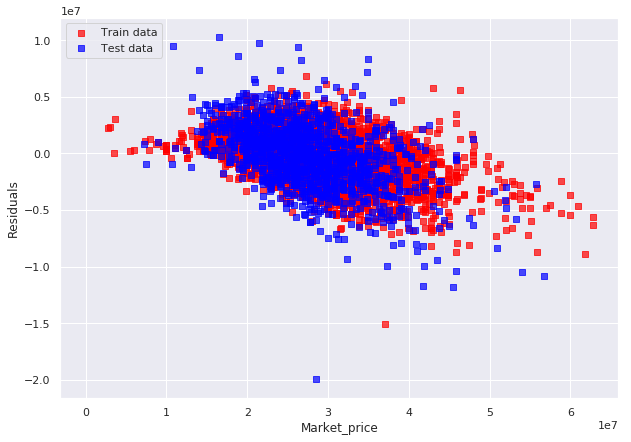

In [55]:
%matplotlib inline
sns.set()

# プロット
plt.figure(figsize = (10, 7))
plt.scatter(y_train, y_train_pred - y_train, c = 'red', marker = 's', s = 35, alpha = 0.7, label = 'Train data')
plt.scatter(y_test, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Market_price')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2)
# plt.xlim([-10, 20000000])
# plt.ylim([-10000000,10000000])
plt.show()

In [56]:
!pip install shap

     |████████████████████████████████| 235kB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


In [57]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model =xgb_model,
                               feature_dependence ='tree_path_dependent',
                               model_output = 'margin' )

In [0]:
shap_values = explainer.shap_values(X_train)

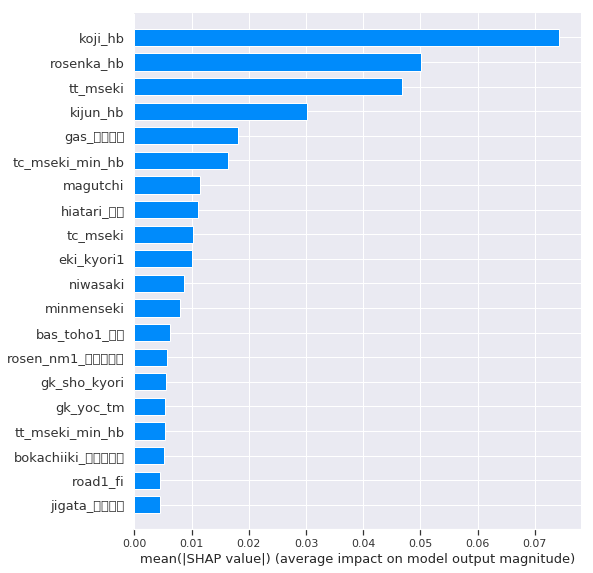

In [59]:
sns.set()
shap.summary_plot(shap_values,X_train,plot_type = 'bar')

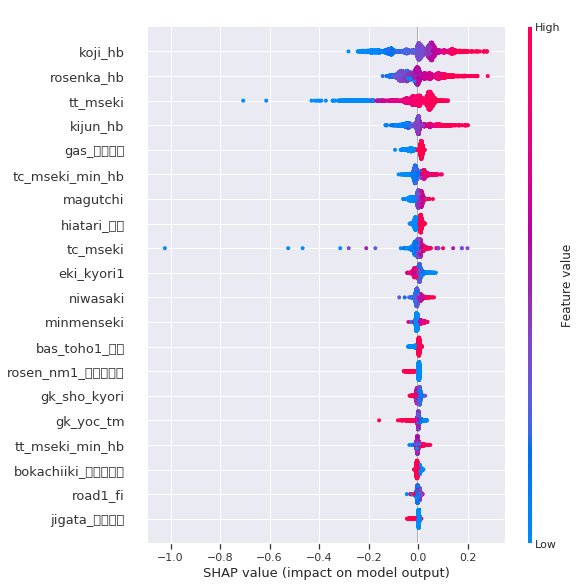

In [60]:
shap.summary_plot(shap_values,X_train)

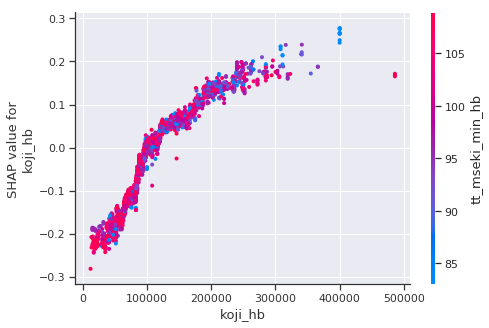

In [61]:
shap.dependence_plot(ind="koji_hb", shap_values=shap_values, features=X_train)

# LightGBM

In [0]:
# データ分割
target = 'keiyaku_pr'
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df_merge_train,test_size = 0.2, random_state = 2)
columns = df_merge_train.columns.values

X_train = df_train.drop(columns = target)
y_train = df_train[target]

X_test = df_test.drop(columns = target)
y_test = df_test[target]

In [0]:
import lightgbm as lgb
do_grid_search = False

def run_grid_search():
  params={
        'learning_rate': [0.05, 0.1,0.5,1],
        'max_depth': [3,5,6,7,8],
        'min_data_in_leaf': [1],
        'n_estimators': [50, 100,200],
        'bagging_fraction': [0.8,1],
        'feature_fraction': [0.8,1.0],
  }
  lgb_model = GridSearchCV(lgb.LGBMRegressor(),params,cv = 5,verbose = 1)
  lgb_model.fit(X_train,y_train)
  return lgb_model

if do_grid_search:
  lgb_model = run_grid_search()
  print(lgb_model.best_estimator_)
  print(lgb_model.best_score_)
else:
    lgb_model =lgb.LGBMRegressor(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.8,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=1,
              min_split_gain=0.0, n_estimators=200,num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)
    lgb_model.fit(X_train,y_train)

In [64]:
# 価格予測
y_train_pred = np.expm1(lgb_model.predict(X_train))
y_test_pred =  np.expm1(lgb_model.predict(X_test))

# logを外す
y_train =np.expm1(y_train)
y_test =np.expm1(y_test)

# 目的変数logとる
def mean_absolute_percentage_error(y_test, y_test_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_test_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print(y_test.describe())
print('train_RMSE:' ,train_rmse)
print('test_RMSE:' ,test_rmse)
print('train_MAPE',mean_absolute_percentage_error(y_train, y_train_pred))
print('test_MAPE',mean_absolute_percentage_error(y_test, y_test_pred))

count    1.293000e+03
mean     2.743737e+07
std      6.760280e+06
min      7.200000e+06
25%      2.280000e+07
50%      2.680000e+07
75%      3.120000e+07
max      5.680000e+07
Name: keiyaku_pr, dtype: float64
train_RMSE: 1693105.3769000105
test_RMSE: 2805944.6400175337
train_MAPE 4.886777872781837
test_MAPE 8.032096102350165


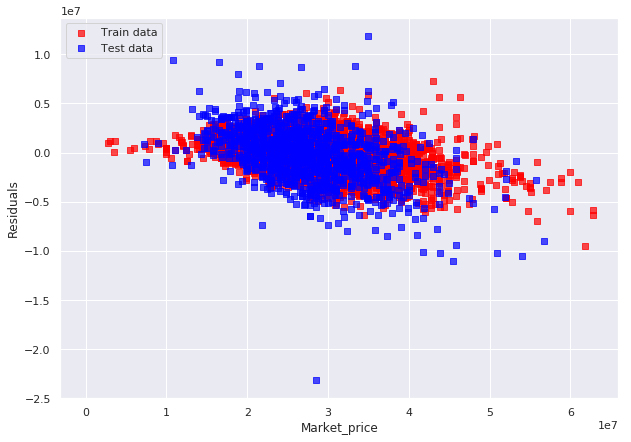

In [65]:
%matplotlib inline
sns.set()

# プロット
plt.figure(figsize = (10, 7))
plt.scatter(y_train, y_train_pred - y_train, c = 'red', marker = 's', s = 35, alpha = 0.7, label = 'Train data')
plt.scatter(y_test, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Market_price')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2)
# plt.xlim([-10, 20000000])
# plt.ylim([-10000000,10000000])
plt.show()

In [66]:
!pip install shap

In [67]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model =lgb_model,
                               feature_dependence ='tree_path_dependent',
                               model_output = 'margin' )

In [0]:
shap_values = explainer.shap_values(X_train)

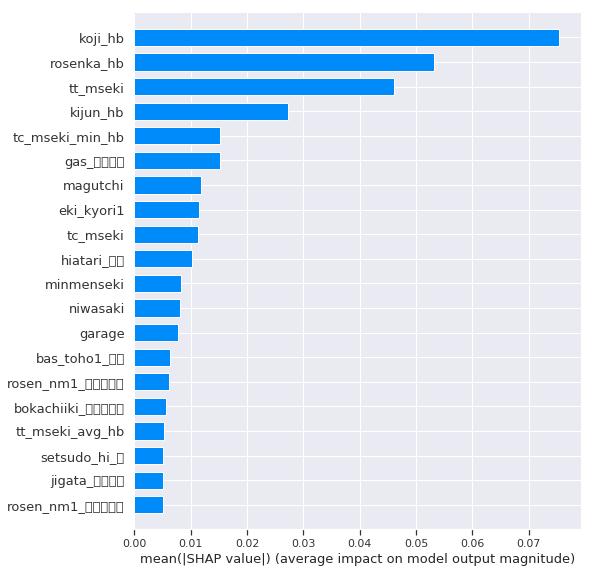

In [69]:
sns.set()
shap.summary_plot(shap_values,X_train,plot_type = 'bar')

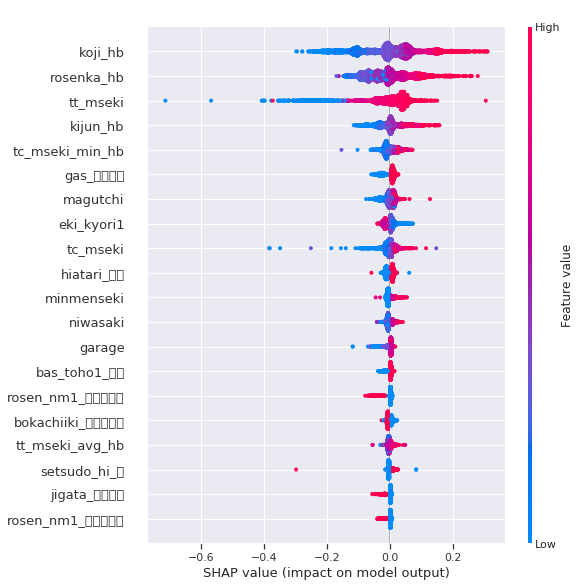

In [70]:
shap.summary_plot(shap_values,X_train)

In [0]:
# shap.dependence_plot(ind="koji_hb", shap_values=shap_values, features=X_train)

# Ensamble

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

In [0]:
# データ分割
target = 'keiyaku_pr'
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df_merge_train,test_size = 0.2, random_state = 3)
columns = df_merge_train.columns.values

X_train = df_train.drop(columns = target)
y_train = df_train[target]

X_test = df_test.drop(columns = target)
y_test = df_test[target]

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfolds = KFold(n_splits = 5 , shuffle = True , random_state = 0)

def cv_rmse(model, X=X_train):
  rmse = np.sqrt(-cross_val_score(model,X_train,y_train,
                                  scoring = "neg_mean_squared_error", cv=kfolds))
  return(rmse)

In [108]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors=(lr_model,lasso_model,ridge_model,lgb_model),
                                meta_regressor=xgb_model,
                                use_features_in_secondary=True)
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

[12:04:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[12:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
def blend_models_predict(X_test):
    return ((0.20* stack_gen_model.predict(X_test)) + \
            (0.15* xgb_model.predict(X_test)) + \
            (0.15* lr_model.predict(X_test)) + \
            (0.15 * lasso_model.predict(X_test)) + \
            (0.2* ridge_model.predict(X_test)) + \
            (0.15* lgb_model.predict(np.array(X_test))))

In [110]:
# 価格予測
y_train_pred = np.expm1(blend_models_predict(X_train))
y_test_pred =  np.expm1(blend_models_predict(X_test))

# # logを外す
y_train =np.expm1(y_train)
y_test =np.expm1(y_test)

ValueError: ignored

In [0]:
# 目的変数logとる
def mean_absolute_percentage_error(y_test, y_test_pred): 
    y_test, y_pred = np.array(y_test), np.array(y_test_pred)
    return np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print(y_test.describe())
print('train_RMSE:' ,train_rmse)
print('test_RMSE:' ,test_rmse)
print('train_MAPE',mean_absolute_percentage_error(y_train, y_train_pred))
print('test_MAPE',mean_absolute_percentage_error(y_test, y_test_pred))

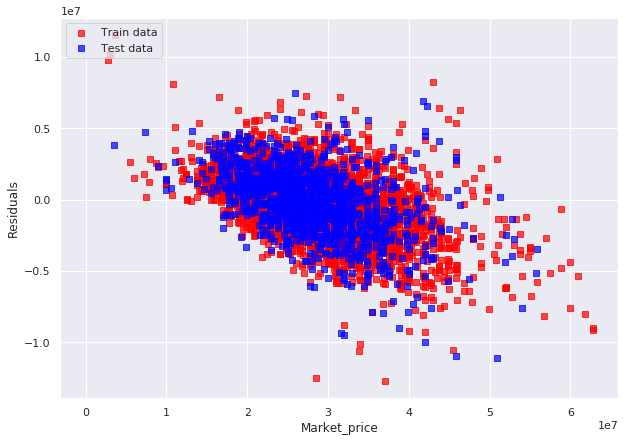

In [99]:
%matplotlib inline
sns.set()

# プロット
plt.figure(figsize = (10, 7))
plt.scatter(y_train, y_train_pred - y_train, c = 'red', marker = 's', s = 35, alpha = 0.7, label = 'Train data')
plt.scatter(y_test, y_test_pred - y_test, c = 'blue', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Market_price')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2)
# plt.xlim([-10, 20000000])
# plt.ylim([-10000000,10000000])
plt.show()

# Submit

In [0]:
# 提出ファイル作成
df_merge_sub = df_merge[len(df_merge_train):]
df_merge_sub = df_merge_sub.drop(columns = 'keiyaku_pr')

In [0]:
sub = df_merge_sub
sub[target] = blend_models_predict(df_merge_sub)

In [102]:
sub['id'] = df_goto_sub['id']
sub_file = pd.DataFrame({"id":sub['id'],target:sub[target]})
sub_file['keiyaku_pr'] = np.expm1(sub_file['keiyaku_pr'] ) 
sub_file.to_csv('sub_file.tsv',sep = '\t',index = False,header = None)
sub_file.head()

,id,keiyaku_pr
0,test_0000,2.186753e+07
1,test_0001,2.664466e+07
2,test_0002,2.572018e+07
3,test_0003,2.747636e+07
4,test_0004,2.661928e+07


In [0]:
# submitするか確認！！！

In [104]:
# !signate submit --competition-id=162 sub_file.tsv --note Ensamble_xgb_lr_lasso_ridge_lgb

You have successfully submitted your predictions. We will send you the submission result to your email address.
